(Reliability Statistics and Predictive Calibration)=
# Reliability Statistics and Predictive Calibration

:::{post} January, 2023
:tags: time-to-failure, prediction, calibration
:category: intermediate
:author: Nathaniel Forde
:::

In [538]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import lognorm, norm, weibull_min
from io import StringIO
from lifelines import (WeibullFitter, LogNormalFitter, KaplanMeierFitter)
from lifelines.utils import survival_table_from_events

from pymc.sampling_jax import sample_blackjax_nuts

In [ ]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Reliability Statistics 

When we want to make inferences about likely failures on a production line. We may have large or small sample data set depending on the industry, nature of the goods or specificifty of the question we're seeking to answer. But in all cases there is a question of cost and a quantity of tolerable failures. In an industry where the line-item cost-profit ratio is clear, the estimation of failure rates is valuable. In an industry where failures are only tangentially related to a bottom line it is arguably even more crucial to correctly predict likely failures - otherwise the uncertainty propagates forward to make the revenue calculations next to impossible. 

A reliability study therefore has to account for the period in which a failure is important to observe, the cost of the failure and cost of running a mis-specified study. The requirements for precision in the definition of the question and the nature of the modelling exercise are paramount. 

There are more subtleties about reliability and failure time data such as censoring, accelerated life test data and degradation testing which we'll discuss briefly below. In this notebook we're going to focus on the prediction of failure times and compare the Bayesian notion of a calibrated prediction interval to some frequentist alternatives. 

### Types of Prediction

We might want to know:

- Time to failure of a new item
- Time until k failures in a future sample of m units
- Number of failures by time t in future sample of m units.

While there are non-parametric and descriptive methods that can be used to assess these kinds of question we're going to focus on the case where we have a probability model i.e. a lognormal distribution of failure times $F(t: \mathbf{\theta})$ parameterised by an unknown $\mathbf{\theta}$. 

### Example Failure Distribution

In the study of reliability statistics there is a focus on location-scale based distributions with long tails. In an ideal world we'd know exactly which distribution described our failure process and the prediction interval for the next failure could be defined exactly. 

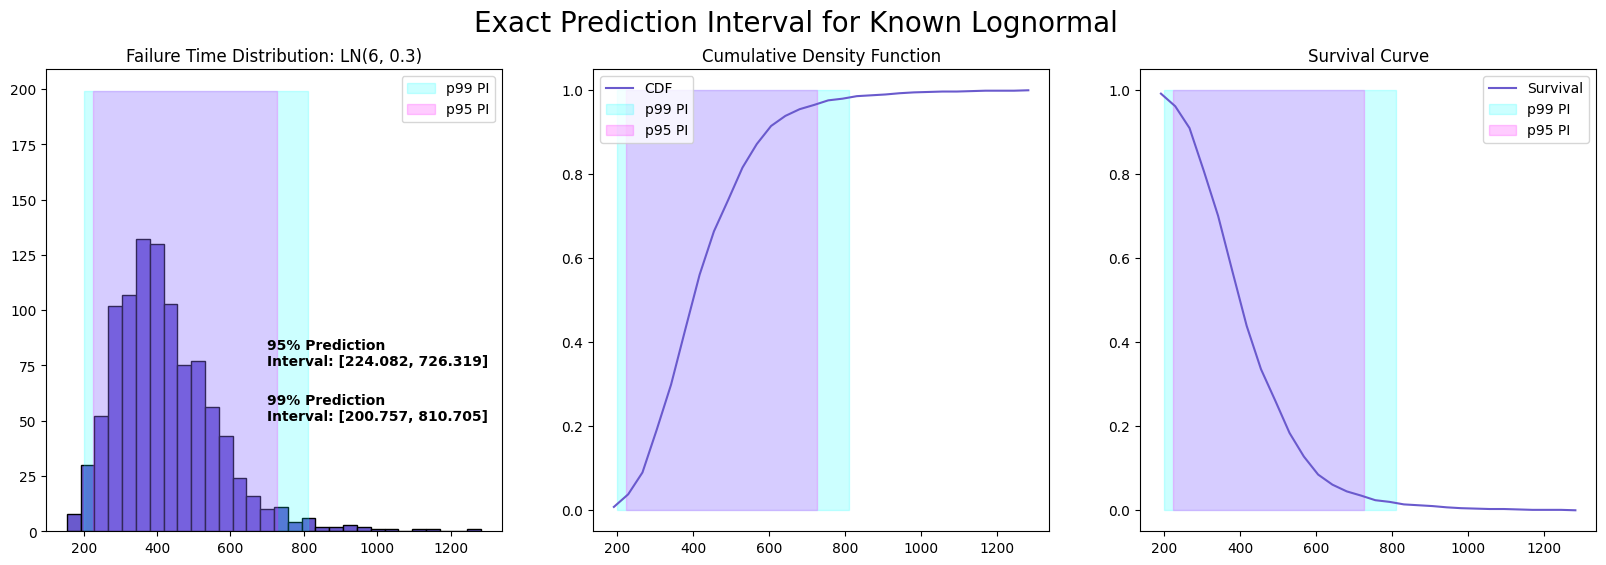

In [1631]:
from scipy.stats import lognorm
mu, sigma = 6,  0.3
def plot_ln_pi(mu, sigma, xy=(700, 75), title="Exact Prediction Interval for Known Lognormal"):
    failure_dist = lognorm(s=sigma, scale=np.exp(mu))
    samples = failure_dist.rvs(size=1000, random_state=100)
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    axs = axs.flatten()
    axs[0].hist(samples, ec='black', color='slateblue', bins=30)
    axs[0].set_title(f'Failure Time Distribution: LN({mu}, {sigma})')
    count, bins_count = np.histogram(samples, bins=30)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    axs[1].plot(bins_count[1:], cdf, label="CDF", color='slateblue')
    axs[2].plot(bins_count[1:], 1-cdf, label="Survival", color='slateblue')
    axs[2].legend()
    axs[1].legend()
    axs[1].set_title("Cumulative Density Function")
    axs[2].set_title("Survival Curve");

    lb = failure_dist.ppf(0.01)
    ub = failure_dist.ppf(0.99)
    axs[0].annotate(f'99% Prediction \nInterval: [{np.round(lb, 3)}, {np.round(ub, 3)}]', xy=(xy[0], xy[1]-25), fontweight='bold')
    axs[0].fill_betweenx(y=range(200), x1=lb, x2=ub, alpha=0.2, label='p99 PI', color='cyan')
    axs[1].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label='p99 PI', color='cyan')
    axs[2].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label='p99 PI', color='cyan')
    lb = failure_dist.ppf(0.025)
    ub = failure_dist.ppf(0.975)
    axs[0].annotate(f'95% Prediction \nInterval: [{np.round(lb, 3)}, {np.round(ub, 3)}]', xy=(xy[0], xy[1]), fontweight='bold')
    axs[0].fill_betweenx(y=range(200), x1=lb, x2=ub, alpha=0.2, label='p95 PI', color='magenta')
    axs[1].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label='p95 PI', color='magenta')
    axs[2].fill_betweenx(y=range(2), x1=lb, x2=ub, alpha=0.2, label='p95 PI', color='magenta')
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    plt.suptitle(title, fontsize=20);

plot_ln_pi(mu, sigma)

## Estimation of the Failure Distribution from Data

In the real world we rarely have such exact knowledge. Instead we start with altogether less clear data. We will examine failure data about heat exchanges across three plants and pool the information to quantify the lifetime of the heat-exchanges over the three factories. 

The data is small deliberately so we can focus on the descriptive statistics involved in assessing time-to-failure data. We will generalise this style of analysis to a larger data set afterwards. 

**Note on Censored Data**:
See how the failure data flags whether or not an observation has been censored i.e. whether or not we have observed the full course of the life-time of the heat-exchanger. This is a crucial feature of failure time data. Too simple a statistical summary will be biased in its estimation of the prevalance of failure by the fact that our study has not seen out the full-course of every item's life-cylce. The most prevalent form of censoring is so called "Right censored" data where we have seen out the "failure" but left censoring and interval censoring can also occur. 

In [336]:
heat_exchange_df = pd.read_csv(StringIO("""Years Lower,Years Upper,Censoring Indicator,Count,Plant
0,1,Left,1,1
1,2,Interval,2,1
2,3,Interval,2,1
3, ,Right,95,1
0,1,Left,2,2
1,2,Interval,3,2
2, ,Right,95,2
0,1,Left,1,3
1, ,Right,99,3

"""))

heat_exchange_df['year_interval'] =  heat_exchange_df['Years Lower'].astype(str) + ',' +   heat_exchange_df['Years Upper'].astype(str)
heat_exchange_df['failed'] = np.where(heat_exchange_df['Censoring Indicator'] != 'Right', heat_exchange_df['Count'], 0)
heat_exchange_df['censored'] = np.where(heat_exchange_df['Censoring Indicator'] == 'Right', heat_exchange_df['Count'], 0)
heat_exchange_df['risk_set'] = [100, 99, 97, 0, 100, 98, 0, 100, 0]
heat_exchange_df

,Years Lower,Years Upper,Censoring Indicator,Count,Plant,year_interval,failed,censored,risk_set
0,0,1,Left,1,1,"0,1",1,0,100
1,1,2,Interval,2,1,"1,2",2,0,99
2,2,3,Interval,2,1,"2,3",2,0,97
3,3,,Right,95,1,"3,",0,95,0
4,0,1,Left,2,2,"0,1",2,0,100
5,1,2,Interval,3,2,"1,2",3,0,98
6,2,,Right,95,2,"2,",0,95,0
7,0,1,Left,1,3,"0,1",1,0,100
8,1,,Right,99,3,"1,",0,99,0


In [1149]:
actuarial_table = heat_exchange_df.groupby(['Years Upper'])[['failed', 'risk_set']].sum()
actuarial_table = actuarial_table.tail(3)

def greenwood_variance(df):
    ### Used to estimate the variance in the CDF
    n = len(df) 
    ps = [df.iloc[i]['p_hat'] / (df.iloc[i]['risk_set']*df.iloc[i]['1-p_hat']) for i in range(n)]
    s = [(df.iloc[i]['S_hat']**2)*np.sum(ps[0:i+1]) for i in range(n)]
    return s

def logit_transform_interval(df):
    ### Used for robustness in the estimation of the Confidence intervals in the CDF
    df['logit_CI_95_lb'] = df['F_hat'] / (df['F_hat'] + df['S_hat']*np.exp((1.960*df['Standard_Error'])/(df['F_hat']*df['S_hat'])))
    df['logit_CI_95_ub'] = df['F_hat'] / (df['F_hat'] + df['S_hat']/np.exp((1.960*df['Standard_Error'])/(df['F_hat']*df['S_hat'])))
    df['logit_CI_95_lb']  =  np.where(df['logit_CI_95_lb']  < 0, 0,  df['logit_CI_95_lb'])
    df['logit_CI_95_ub']  =  np.where(df['logit_CI_95_ub']  > 1, 1,  df['logit_CI_95_ub'])
    return df

def make_actuarial_table(actuarial_table):
    lb = 0.000000000000000001
    ### Actuarial lifetables are used to describe the nature of the risk over time and estimate
    actuarial_table['p_hat'] = actuarial_table['failed'] / actuarial_table['risk_set'] 
    actuarial_table['1-p_hat'] = 1 - actuarial_table['p_hat']
    actuarial_table['S_hat'] = actuarial_table['1-p_hat'].cumprod()
    actuarial_table['CH_hat'] = -np.log(actuarial_table['S_hat'])
    actuarial_table['F_hat'] = 1 - actuarial_table['S_hat']
    actuarial_table['V_hat'] = greenwood_variance(actuarial_table)
    actuarial_table['Standard_Error'] = np.sqrt(actuarial_table['V_hat'])
    actuarial_table['CI_95_lb'] = actuarial_table['F_hat'] - actuarial_table['Standard_Error']*1.960
    actuarial_table['CI_95_lb'] = np.where(actuarial_table['CI_95_lb'] < 0, lb, actuarial_table['CI_95_lb'])
    actuarial_table['CI_95_ub'] = actuarial_table['F_hat'] + actuarial_table['Standard_Error']*1.960
    actuarial_table['CI_95_ub'] = np.where(actuarial_table['CI_95_ub'] > 1, 1, actuarial_table['CI_95_ub'])
    actuarial_table['ploting_position'] = actuarial_table['F_hat'].rolling(1).sum()
    actuarial_table['ploting_position'] = actuarial_table['ploting_position']*.5
    actuarial_table  = logit_transform_interval(actuarial_table)
    return actuarial_table

actuarial_table_heat = make_actuarial_table(actuarial_table)
actuarial_table_heat = actuarial_table_heat.reset_index()
actuarial_table_heat.rename({'Years Upper': 't'}, axis=1, inplace=True)
actuarial_table_heat['t'] = actuarial_table_heat['t'].astype(int)
actuarial_table_heat

,t,failed,risk_set,p_hat,1-p_hat,S_hat,CH_hat,F_hat,V_hat,Standard_Error,CI_95_lb,CI_95_ub,ploting_position,logit_CI_95_lb,logit_CI_95_ub
0,1,4,300,0.01333,0.98667,0.98667,0.01342,0.01333,0.00004,0.00662,0.00035,0.02631,0.00667,0.00501,0.03498
1,2,5,197,0.02538,0.97462,0.96162,0.03913,0.03838,0.00016,0.01280,0.01328,0.06347,0.01919,0.01982,0.07302
2,3,2,97,0.02062,0.97938,0.94180,0.05997,0.05820,0.00035,0.01870,0.02155,0.09486,0.02910,0.03069,0.10763


It's worth taking some time to walk through this example because it establishes estimates of some key quantities in time-to-failure modelling. First we've established across all three companies in three consecutive years the number of heat-exchanges that were produced and subsequently failed. This provides and estimate of the probability of failure in the year. `p_hat` and its inverse `1-p_hat` respectively. These are further combined over the course of the year to estimate the survival curve `S_hat` which can be further transformed to recover estimates of the cumulative hazard `CH_hat` and the cumulative density function `F_hat`. 

Next we want a quick a dirty way to quantify the extent of the uncertainty in our estimate of the CDF. For this purpose we use greenwood's formula to estimate the variance of our `V_hat` of our estimate `F_hat`. This gives us the standard error and the two varieties of confidence interval recommended in the literature. 

We' apply the same techniques to a larger dataset and plot some of these quantities below. 

In [1118]:
shockabsorbers_df = pd.read_csv(StringIO("""Kilometers,Failure Mode,Censoring Indicator
6700,Mode1,Failed
6950,Censored,Censored
7820,Censored,Censored
8790,Censored,Censored
9120,Mode2,Failed
9660,Censored,Censored
9820,Censored,Censored
11310,Censored,Censored
11690,Censored,Censored
11850,Censored,Censored
11880,Censored,Censored
12140,Censored,Censored
12200,Mode1,Failed
12870,Censored,Censored
13150,Mode2,Failed
13330,Censored,Censored
13470,Censored,Censored
14040,Censored,Censored
14300,Mode1,Failed
17520,Mode1,Failed
17540,Censored,Censored
17890,Censored,Censored
18450,Censored,Censored
18960,Censored,Censored
18980,Censored,Censored
19410,Censored,Censored
20100,Mode2,Failed
20100,Censored,Censored
20150,Censored,Censored
20320,Censored,Censored
20900,Mode2,Failed
22700,Mode1,Failed
23490,Censored,Censored
26510,Mode1,Failed
27410,Censored,Censored
27490,Mode1,Failed
27890,Censored,Censored
28100,Censored,Censored
"""))

shockabsorbers_df['failed'] = np.where(shockabsorbers_df['Censoring Indicator'] == 'Failed', 1, 0)
shockabsorbers_df['t'] = shockabsorbers_df['Kilometers']
shockabsorbers_events = survival_table_from_events(shockabsorbers_df['t'], shockabsorbers_df['failed']).reset_index()
shockabsorbers_events.rename({'event_at': 't', 'observed': 'failed', 'at_risk': 'risk_set'}, axis=1, inplace=True)
actuarial_table_shock = make_actuarial_table(shockabsorbers_events)
actuarial_table_shock


,t,removed,failed,censored,entrance,risk_set,p_hat,1-p_hat,S_hat,CH_hat,F_hat,V_hat,Standard_Error,CI_95_lb,CI_95_ub,ploting_position_lb,ploting_position_ub,logit_CI_95_lb,logit_CI_95_ub
0,0.0,0,0,0,38,38,0.000000,1.000000,1.000000,-0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,NaN,NaN
1,6700.0,1,1,0,0,38,0.026316,0.973684,0.973684,0.026668,0.026316,0.000674,0.025967,1.000000e-18,0.077212,5.000000e-19,0.038606,0.003694,0.164570
2,6950.0,1,0,1,0,37,0.000000,1.000000,0.973684,0.026668,0.026316,0.000674,0.025967,1.000000e-18,0.077212,5.000000e-19,0.038606,0.003694,0.164570
3,7820.0,1,0,1,0,36,0.000000,1.000000,0.973684,0.026668,0.026316,0.000674,0.025967,1.000000e-18,0.077212,5.000000e-19,0.038606,0.003694,0.164570
4,8790.0,1,0,1,0,35,0.000000,1.000000,0.973684,0.026668,0.026316,0.000674,0.025967,1.000000e-18,0.077212,5.000000e-19,0.038606,0.003694,0.164570
5,9120.0,1,1,0,0,34,0.029412,0.970588,0.945046,0.056521,0.054954,0.001431,0.037831,1.000000e-18,0.129103,5.000000e-19,0.064552,0.013755,0.195137
6,9660.0,1,0,1,0,33,0.000000,1.000000,0.945046,0.056521,0.054954,0.001431,0.037831,1.000000e-18,0.129103,5.000000e-19,0.064552,0.013755,0.195137
7,9820.0,1,0,1,0,32,0.000000,1.000000,0.945046,0.056521,0.054954,0.001431,0.037831,1.000000e-18,0.129103,5.000000e-19,0.064552,0.013755,0.195137
8,11310.0,1,0,1,0,31,0.000000,1.000000,0.945046,0.056521,0.054954,0.001431,0.037831,1.000000e-18,0.129103,5.000000e-19,0.064552,0.013755,0.195137
9,11690.0,1,0,1,0,30,0.000000,1.000000,0.945046,0.056521,0.054954,0.001431,0.037831,1.000000e-18,0.129103,5.000000e-19,0.064552,0.013755,0.195137


### Maximum Likelihood Fits for Failure Data

In addition to taking descriptive summaries of our data we can use the life-table data to estimate a univariate model fit to our distribution of failure times. Such a fit, if good would enable us to have a clearer view of the predictive distribution a particular predictive intervals. Here we'll use the functions from the  `lifelines` package to estimate the MLE fit on right-censored data. 

In [1120]:
lnf = LogNormalFitter().fit(actuarial_table_shock['t'] + 0.00000000000001, actuarial_table_shock['failed'])
lnf.print_summary()

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 38 total observations, 27 right-censored observations>
   number of observations = 38
number of events observed = 11
           log-likelihood = -124.20
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%
mu_     10.13       0.14             9.85            10.41
sigma_   0.53       0.11             0.31             0.74

         cmp to     z      p   -log2(p)
mu_        0.00 71.08 <0.005        inf
sigma_     1.00 -4.26 <0.005      15.58
---
AIC = 252.41

Although it's tempting to take this model and run with it, we need to be cautious in the case of limited data. For instance in the heat-exchange data we have three years of data with a total of 11 failures. A too simple model can get this quite wrong. 

We can see this with a graphical test of goodness of fit when comparing the model fit to the non-parametric estimates of our CDF and the uncertainty interval. 

In [1502]:
def plot_cdfs(actuarial_table, dist_fits=True, ax=None, title='', xy=(3000, .5), weights=None):
    lnf = LogNormalFitter().fit(actuarial_table['t'] + 0.00000000000001, actuarial_table['failed'])
    wbf = WeibullFitter().fit(actuarial_table['t'] + 0.00000000000001, actuarial_table['failed'])
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 8))
    ax.plot(actuarial_table['t'], actuarial_table['F_hat'], '-o', color='black', label='Non-Parametric Estimate of CDF')
    ax.plot(actuarial_table['t'], actuarial_table['CI_95_lb'], color='darkorchid', linestyle='--', label='Non-Parametric 95% CI based on Normal Approx')
    ax.plot(actuarial_table['t'], actuarial_table['CI_95_ub'], color='darkorchid', linestyle='--')
    ax.fill_between(actuarial_table['t'], actuarial_table['CI_95_lb'], actuarial_table['CI_95_ub'], color='darkorchid', alpha=0.2)
    ax.plot(actuarial_table['t'], actuarial_table['logit_CI_95_lb'], color='royalblue', linestyle='--', label='Non-Parametric 95% CI based on Logit Approx')
    ax.plot(actuarial_table['t'], actuarial_table['logit_CI_95_ub'], color='royalblue', linestyle='--')
    ax.fill_between(actuarial_table['t'], actuarial_table['logit_CI_95_lb'], actuarial_table['logit_CI_95_ub'], color='royalblue', alpha=0.2)
    if dist_fits:
        lnf.plot_cumulative_density(ax=ax, color='crimson', alpha=0.8)
        wbf.plot_cumulative_density(ax=ax, color='cyan', alpha=0.8)
        ax.annotate(f'Lognormal Fit: mu = {np.round(lnf.mu_, 3)}, sigma = {np.round(lnf.sigma_, 3)} \nWeibull Fit: lambda = {np.round(wbf.lambda_, 3)}, rho = {np.round(wbf.rho_, 3)}', xy=(xy[0], xy[1]), fontsize=12, weight='bold')
    ax.set_title(f'Estimates of the Cumulative Density Function \n derived from our {title} Failure Data', fontsize=20)
    ax.set_ylabel('Fraction Failing')
    ax.set_xlabel("Time Scale")
    ax.legend()
    return ax

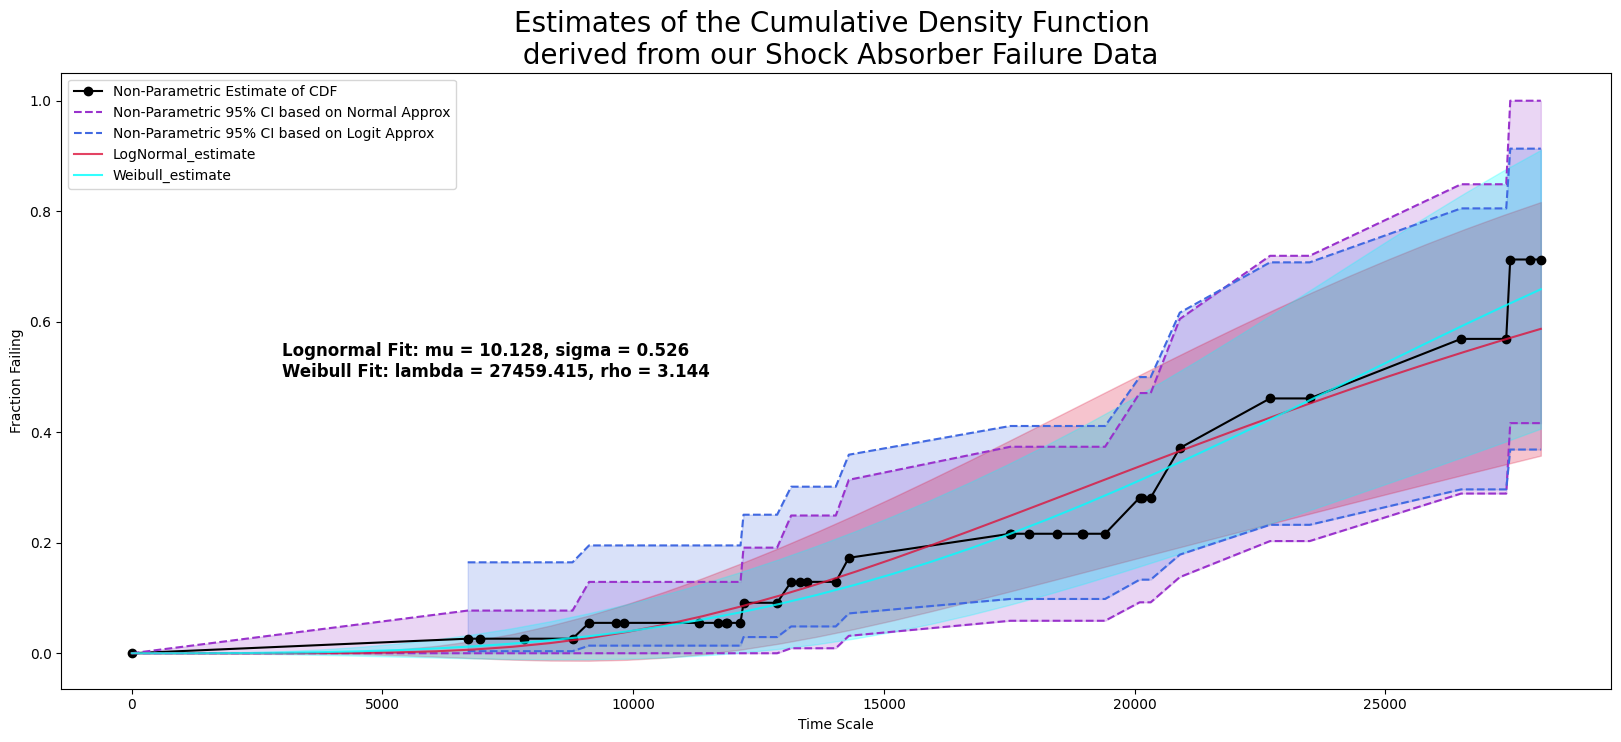

In [1348]:
plot_cdfs(actuarial_table_shock, title='Shock Absorber')

This shows a good fit to the data and implies, as you might expect, that the failing fraction of shock absorbers increases with age as they wear out. 

## The Plug-in-Procedure for calculating Approximate Statistical Prediction Intervals

Since we've estimated a lognormal fit for the CDF of the shock absorbers data we can plot their approximate prediction interval. The interest here is likely to be in the lower bound of the prediction interval since we as manufacturers might want to be aware of warranty claims and the risk of exposure to refunds if the lower bound is too low. 

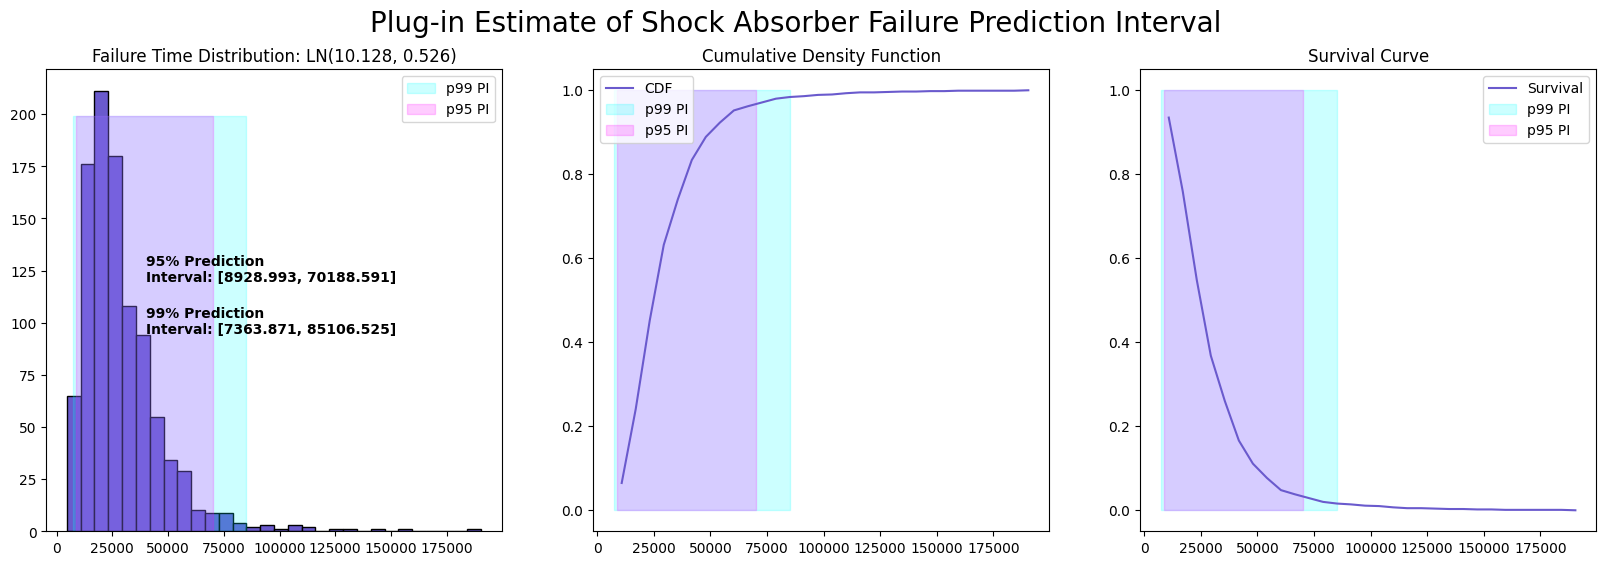

In [1632]:
plot_ln_pi(10.128, 0.526, xy=(40000, 120), title='Plug-in Estimate of Shock Absorber Failure Prediction Interval')

### Bootstrap Calibration and Coverage Estimation

In [1652]:
import random
def bootstrap(lb, ub):
    draws = actuarial_table_shock[['t', 'failed']].sample(replace =True, frac=1)
    draws.sort_values('t', inplace=True)
    lnf = LogNormalFitter().fit(draws['t']+ 0.0000000000000000001, draws['failed'])
    future = random.choice(draws[draws['t'] > 0]['t'].values)
    contained = (future >= lb) & (future <= ub)
    lb = lognorm(s=lnf.sigma_, scale=np.exp(lnf.mu_)).ppf(0.025)
    ub = lognorm(s=lnf.sigma_, scale=np.exp(lnf.mu_)).ppf(0.975)
    return lb, ub, contained, future, lnf.sigma_, lnf.mu_

CIs = [bootstrap(10538, 59467) for i in range(1000)]
draws = pd.DataFrame(CIs, columns=['Lower Bound PI', 'Upper Bound PI', 'Contained', 'future', 'Sigma', 'Mu'])
draws


,Lower Bound PI,Upper Bound PI,Contained,future,Sigma,Mu
0,8596.70288,84887.62273,True,18450.00000,0.58418,10.20411
1,9930.86113,55764.11459,True,17890.00000,0.44018,10.06614
2,8372.59824,49166.80757,True,13330.00000,0.45160,9.91785
3,9233.68146,58639.96692,True,12200.00000,0.47158,10.05489
4,7035.72232,110290.89035,True,18960.00000,0.70208,10.23482
...,...,...,...,...,...,...
4995,8075.15855,66404.79766,True,14300.00000,0.53750,10.05004
4996,14146.25477,39934.00091,False,9820.00000,0.26474,10.07609
4997,9477.60328,96828.30187,True,12200.00000,0.59287,10.31869
4998,8175.79847,54572.11434,True,26510.00000,0.48428,9.95811


Text(0.6, 16000, 'Estimated Prediction Interval \n Coverage Based on Plug in Method : 0.92')

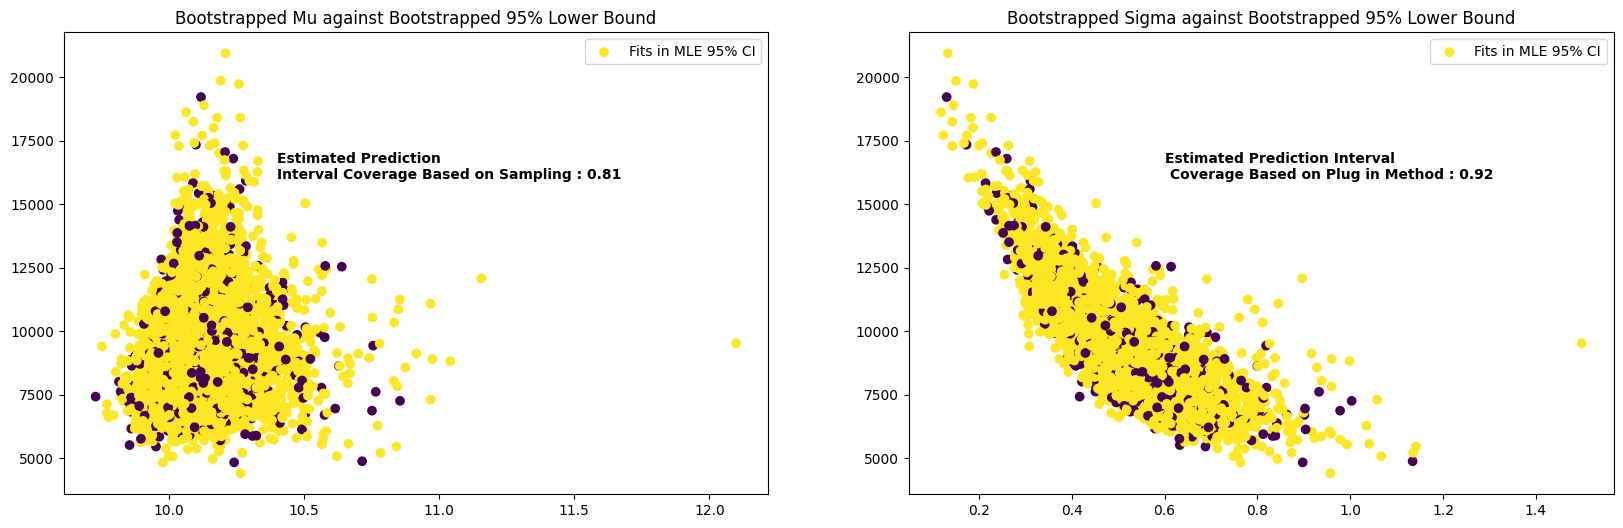

In [1653]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].scatter(draws['Mu'], draws['Lower Bound PI'], c=draws['Contained'], label='Fits in MLE 95% CI')
axs[1].scatter(draws['Sigma'], draws['Lower Bound PI'], c=draws['Contained'], label='Fits in MLE 95% CI')
axs[0].set_title("Bootstrapped Mu against Bootstrapped 95% Lower Bound")
prop = draws['Contained'].sum() / len(draws)
axs[0].annotate(f'Estimated Prediction \nInterval Coverage Based on Sampling : {np.round(prop, 3)}', xy=(10.4, 16000), fontweight='bold')
axs[1].set_title("Bootstrapped Sigma against Bootstrapped 95% Lower Bound")
axs[0].legend()
axs[1].legend()

rv = lognorm(s=draws['Sigma'].mean(), scale=np.exp(draws['Mu'].mean()))
plug_in = np.abs(np.mean(rv.cdf(draws['Lower Bound PI']) - rv.cdf(draws['Upper Bound PI'])))
axs[1].annotate(f'Estimated Prediction Interval \n Coverage Based on Plug in Method : {np.round(plug_in, 3)}', xy=(0.6, 16000), fontweight='bold')


### Bearing Data

Next we'll look at a data set which has a slightly less clean parametric fit. 

In [1431]:
bearing_cage_df = pd.read_csv(StringIO("""Hours,Censoring Indicator,Count
50,Censored,288
150,Censored,148
230,Failed,1
250,Censored,124
334,Failed,1
350,Censored,111
423,Failed,1
450,Censored,106
550,Censored,99
650,Censored,110
750,Censored,114
850,Censored,119
950,Censored,127
990,Failed,1
1009,Failed,1
1050,Censored,123
1150,Censored,93
1250,Censored,47
1350,Censored,41
1450,Censored,27
1510,Failed,1
1550,Censored,11
1650,Censored,6
1850,Censored,1
2050,Censored,2"""))


bearing_cage_df['t'] = bearing_cage_df['Hours']
bearing_cage_df['failed'] = np.where(bearing_cage_df['Censoring Indicator'] == 'Failed', 1, 0)
bearing_cage_df['censored'] = np.where(bearing_cage_df['Censoring Indicator'] == 'Censored', bearing_cage_df['Count'] , 0)
bearing_cage_events = survival_table_from_events(bearing_cage_df['t'], bearing_cage_df['failed'], weights=bearing_cage_df['Count']).reset_index()
bearing_cage_events.rename({'event_at': 't', 'observed': 'failed', 'at_risk': 'risk_set'}, axis=1, inplace=True)
actuarial_table_bearings = make_actuarial_table(bearing_cage_events)
pd.options.display.float_format = '{:.5f}'.format
actuarial_table_bearings


,t,removed,failed,censored,entrance,risk_set,p_hat,1-p_hat,S_hat,CH_hat,F_hat,V_hat,Standard_Error,CI_95_lb,CI_95_ub,ploting_position,logit_CI_95_lb,logit_CI_95_ub
0,0.00000,0,0,0,1703,1703,0.00000,1.00000,1.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN
1,50.00000,288,0,288,0,1703,0.00000,1.00000,1.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN
2,150.00000,148,0,148,0,1415,0.00000,1.00000,1.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN,NaN
3,230.00000,1,1,0,0,1267,0.00079,0.99921,0.99921,0.00079,0.00079,0.00000,0.00079,0.00000,0.00234,0.00039,0.00011,0.00558
4,250.00000,124,0,124,0,1266,0.00000,1.00000,0.99921,0.00079,0.00079,0.00000,0.00079,0.00000,0.00234,0.00039,0.00011,0.00558
5,334.00000,1,1,0,0,1142,0.00088,0.99912,0.99834,0.00167,0.00166,0.00000,0.00118,0.00000,0.00397,0.00083,0.00042,0.00664
6,350.00000,111,0,111,0,1141,0.00000,1.00000,0.99834,0.00167,0.00166,0.00000,0.00118,0.00000,0.00397,0.00083,0.00042,0.00664
7,423.00000,1,1,0,0,1030,0.00097,0.99903,0.99737,0.00264,0.00263,0.00000,0.00152,0.00000,0.00562,0.00132,0.00085,0.00817
8,450.00000,106,0,106,0,1029,0.00000,1.00000,0.99737,0.00264,0.00263,0.00000,0.00152,0.00000,0.00562,0.00132,0.00085,0.00817
9,550.00000,99,0,99,0,923,0.00000,1.00000,0.99737,0.00264,0.00263,0.00000,0.00152,0.00000,0.00562,0.00132,0.00085,0.00817


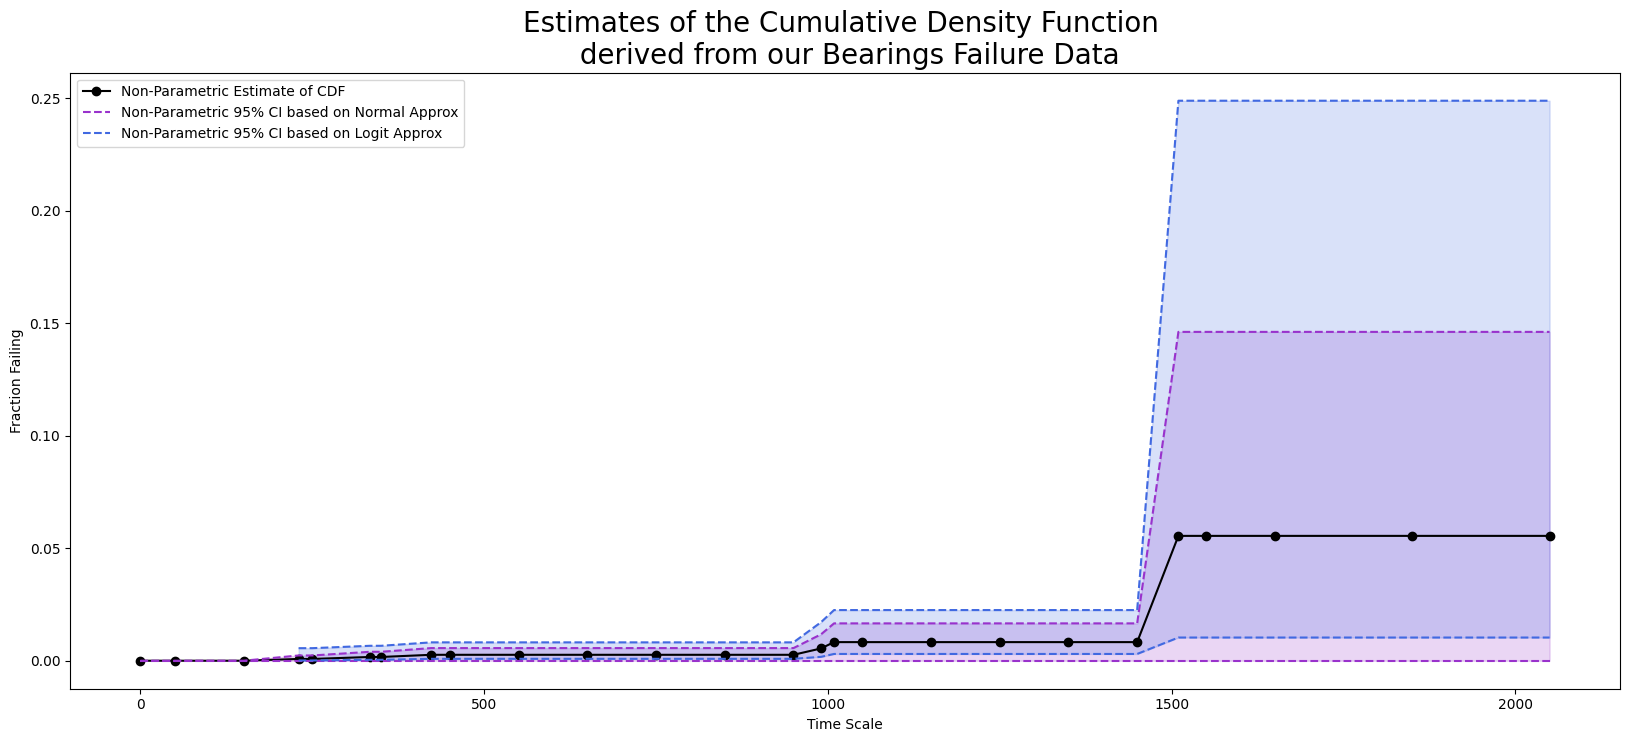

In [1432]:
plot_cdfs(actuarial_table_bearings, title='Bearings', dist_fits=False, xy=(20, 0.7))

## Item Period Data Format

In [1504]:
item_period = bearing_cage_df['Hours'].to_list() * bearing_cage_df['Count'].sum()
ids = [[i]*25 for i in range(bearing_cage_df['Count'].sum())]
ids = [i for l in ids for i in l]
item_period_bearing_cage = pd.DataFrame(item_period, columns=['t'])
item_period_bearing_cage['id'] = ids
item_period_bearing_cage['failed'] = np.zeros(len(item_period_bearing_cage))
for i, f in zip([1, 2, 3, 4, 5, 6], bearing_cage_df[bearing_cage_df['failed'] == 1]['t']):
    item_period_bearing_cage['failed'] = np.where((item_period_bearing_cage['id'] == i) & (item_period_bearing_cage['t'] == f), 1, item_period_bearing_cage['failed'])

item_period_bearing_cage.sum()
item_period_bearing_cage.head(30)

,t,id,failed
0,50,0,0.00000
1,150,0,0.00000
2,230,0,0.00000
3,250,0,0.00000
4,334,0,0.00000
5,350,0,0.00000
6,423,0,0.00000
7,450,0,0.00000
8,550,0,0.00000
9,650,0,0.00000


/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_34858/2646297611.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_34858/2646297611.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_34858/2646297611.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xticks)


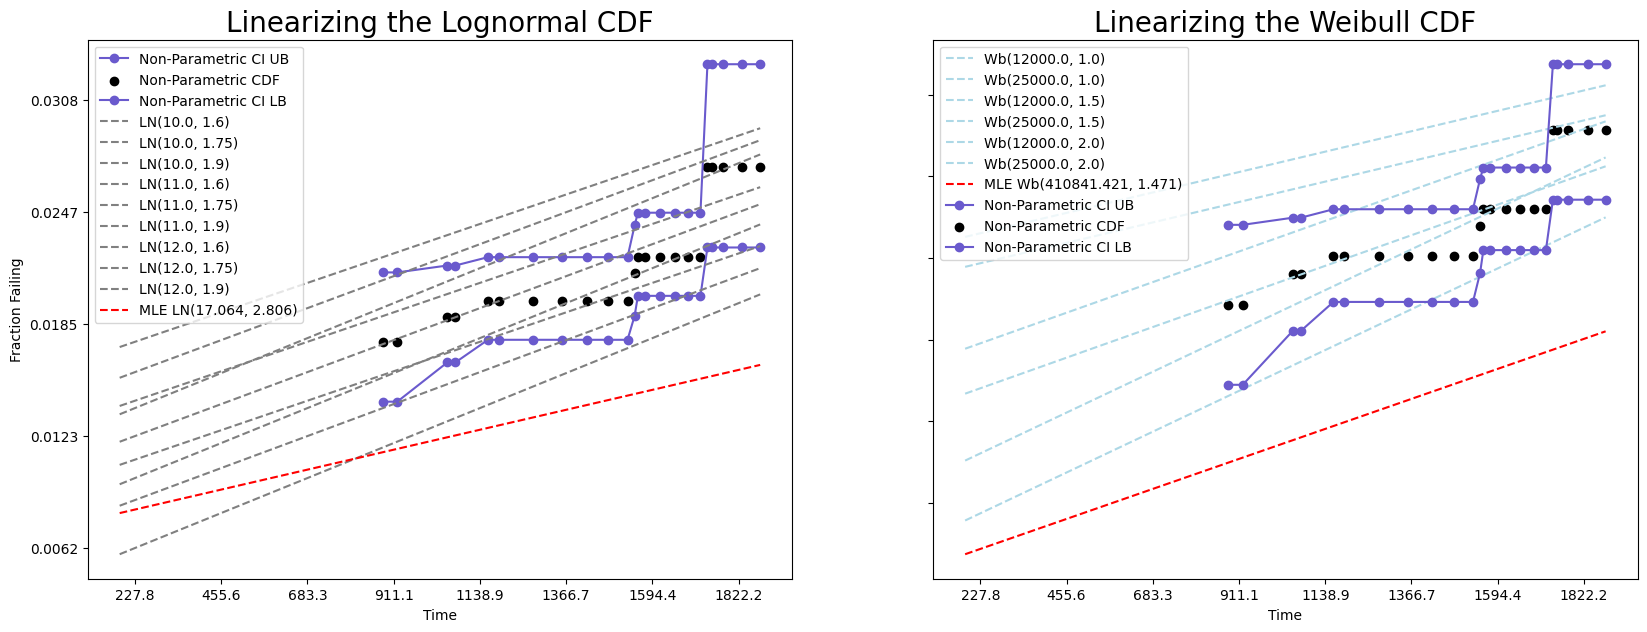

In [1549]:
def sev_ppf(p):
    return np.log(-np.log(1-p))

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs = axs.flatten()
ax = axs[0]
ax2 = axs[1]
ax.plot(np.log(actuarial_table_bearings['t']), norm.ppf(actuarial_table_bearings['logit_CI_95_ub']), '-o', label='Non-Parametric CI UB', color='slateblue')
ax.scatter(np.log(actuarial_table_bearings['t']), norm.ppf(actuarial_table_bearings['F_hat']), label='Non-Parametric CDF', color='black')
ax.plot(np.log(actuarial_table_bearings['t']), norm.ppf(actuarial_table_bearings['logit_CI_95_lb']), '-o', label='Non-Parametric CI LB', color='slateblue')
for mu in np.linspace(10,  12, 3):
    for sigma in np.linspace(1.6, 1.9, 3):
        rv = lognorm(s=sigma, scale=np.exp(mu))
        ax.plot(np.log(actuarial_table_bearings['t']), norm.ppf(rv.cdf(actuarial_table_bearings['t'])), '--', label=f'LN({np.round(mu, 3)}, {np.round(sigma, 3)})', color='grey')

lnf = LogNormalFitter().fit(item_period_bearing_cage['t'], item_period_bearing_cage['failed'])
rv = lognorm(s = lnf.sigma_, scale=np.exp(lnf.mu_))
ax.plot(np.log(actuarial_table_bearings['t']), norm.ppf(rv.cdf(actuarial_table_bearings['t'])), '--', label=f'MLE LN({np.round(lnf.mu_, 3)}, {np.round(lnf.sigma_, 3)})', color='RED')

for r in np.linspace(1, 2, 3):
    for s in  np.linspace(12000, 25000, 2):
        rv = weibull_min(c=r, scale=s)
        ax2.plot(np.log(actuarial_table_bearings['t']), sev_ppf(rv.cdf(actuarial_table_bearings['t'])), '--', label=f'Wb({np.round(s, 3)}, {np.round(r, 3)})', color='lightblue')


wbf = WeibullFitter().fit(item_period_bearing_cage['t'], item_period_bearing_cage['failed'])
rv = weibull_min(c=wbf.rho_, scale=wbf.lambda_)
ax2.plot(np.log(actuarial_table_bearings['t']), sev_ppf(rv.cdf(actuarial_table_bearings['t'])), '--', label=f'MLE Wb({np.round(wbf.lambda_, 3)}, {np.round(wbf.rho_, 3)})', color='red')

ax2.plot(np.log(actuarial_table_bearings['t']), sev_ppf(actuarial_table_bearings['logit_CI_95_ub']), '-o', label='Non-Parametric CI UB', color='slateblue')
ax2.scatter(np.log(actuarial_table_bearings['t']), sev_ppf(actuarial_table_bearings['F_hat']), label='Non-Parametric CDF', color='black')
ax2.plot(np.log(actuarial_table_bearings['t']), sev_ppf(actuarial_table_bearings['logit_CI_95_lb']), '-o', label='Non-Parametric CI LB', color='slateblue')

ax2.set_title("Linearizing the Weibull CDF", fontsize=20)
ax.set_title("Linearizing the Lognormal CDF", fontsize=20)
ax.legend()
ax.set_xlabel("Time")
ax2.set_xlabel("Time")
xticks = np.round(np.linspace(0, actuarial_table_bearings['t'].max(), 10), 1)
yticks = np.round(np.linspace(0, actuarial_table_bearings['F_hat'].max(), 10), 4)
ax.set_xticklabels(xticks)
ax.set_yticklabels(yticks)
ax2.set_xticklabels(xticks)
ax2.set_yticklabels([])
ax2.legend()
ax.set_ylabel("Fraction Failing");

In [1531]:
wbf = WeibullFitter().fit(item_period_bearing_cage['t'] +1e-25, item_period_bearing_cage['failed'])
wbf.summary



,coef,se(coef),coef lower 95%,coef upper 95%,cmp to,z,p,-log2(p)
lambda_,410841.42140,690945.50673,-943386.88706,1765069.72987,1.00000,0.59461,0.55211,0.85698
rho_,1.47050,0.42405,0.63938,2.30163,1.00000,1.10954,0.26720,1.90403


<AxesSubplot: xlabel='fitted weibull quantiles', ylabel='empirical quantiles'>

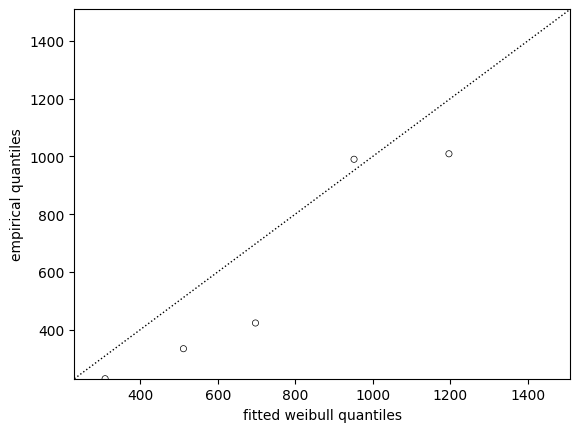

In [1537]:
qq_plot(wbf)

In [1535]:
6/ 1700


0.0035294117647058825

Parametric SurPyval Model
Distribution        : Weibull
Fitted by           : MLE
Max Proportion (p)  : 0.9999995107681628
Parameters          :
     alpha: 1014.7059887437521
      beta: 1.6048305491732209


Precision was lost, try:
- Using alternate fitting method
- visually checking model fit
- change data to be closer to 1.


<AxesSubplot: title={'center': 'Weibull Probability Plot'}, ylabel='CDF'>

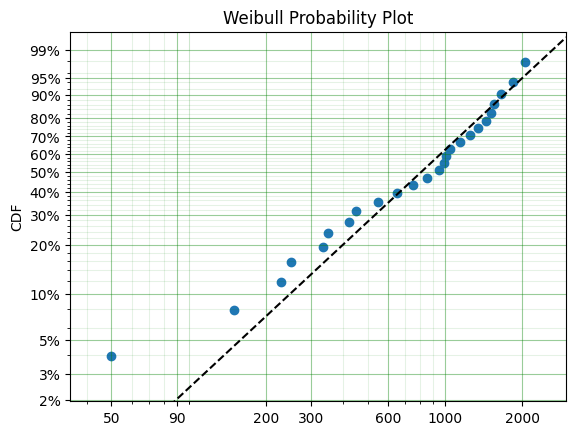

In [1536]:
model = surv.Weibull.fit(item_period_bearing_cage['t'], item_period_bearing_cage['failed'], lfp=True)
print(model)
model.plot()

## Authors

Nathaniel Forde

## Watermark

In [1]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Wed Dec 14 2022

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.4.0

aesara: 2.8.7
aeppl : 0.0.38
xarray: 2022.10.0

sys: 3.9.0 (default, Nov 15 2020, 06:25:35) 
[Clang 10.0.0 ]

Watermark: 2.3.1



:::{include} ../page_footer.md
:::